# Experiment: Kernel Weight Optimization
In this experiment, we investigate the effectiveness of combining multiple kernels in a Gaussian Process (GP) model for predicting search volume trends across three groups: Soccer (D1), Political (D2), and Tech (D3). The focus is on optimizing kernel weights to determine which kernels contribute most significantly to the predictive performance.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components).

In [4]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

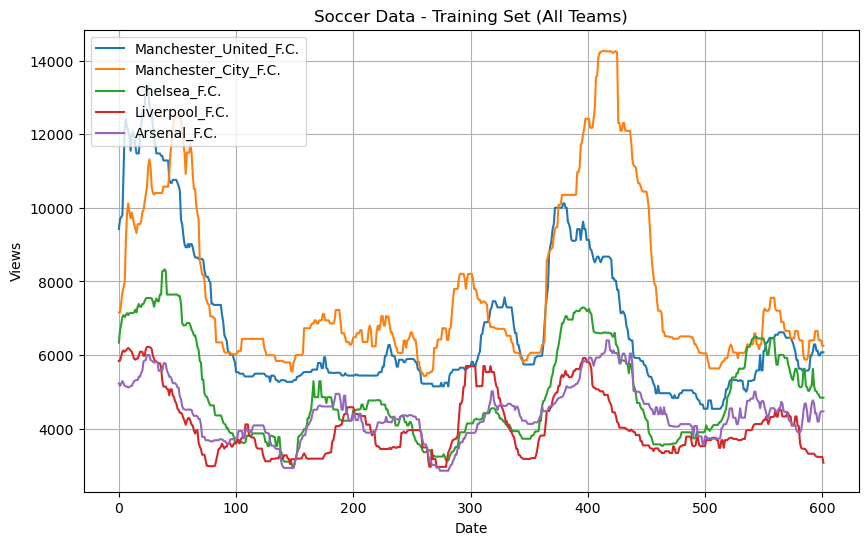

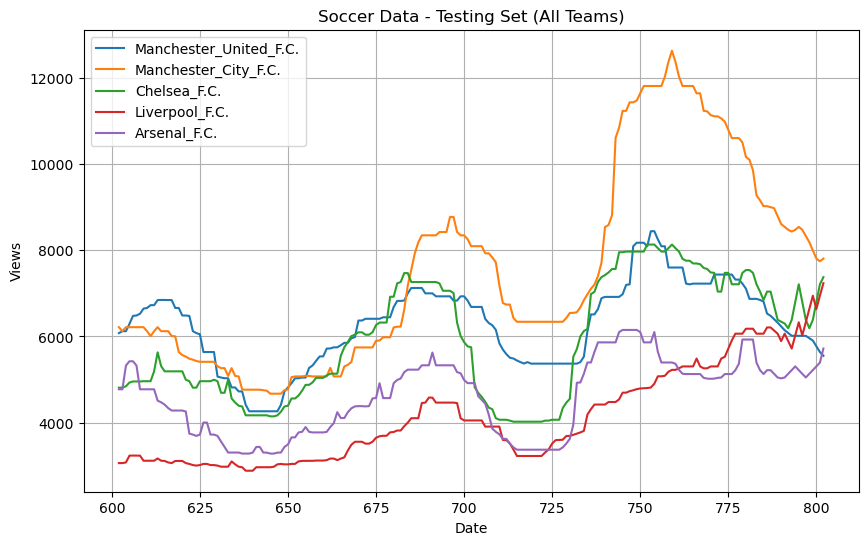

smoothed_test_tech shape: (5, 201)
time_test_tech shape: (201,)


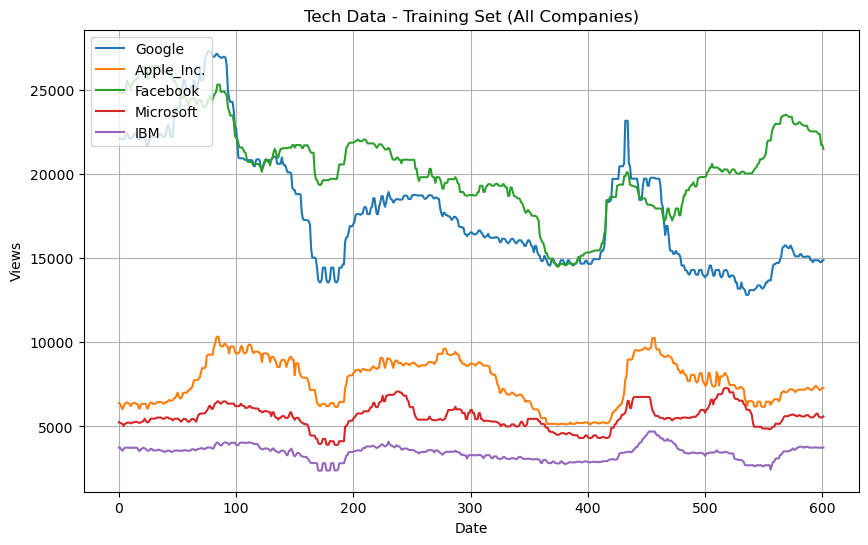

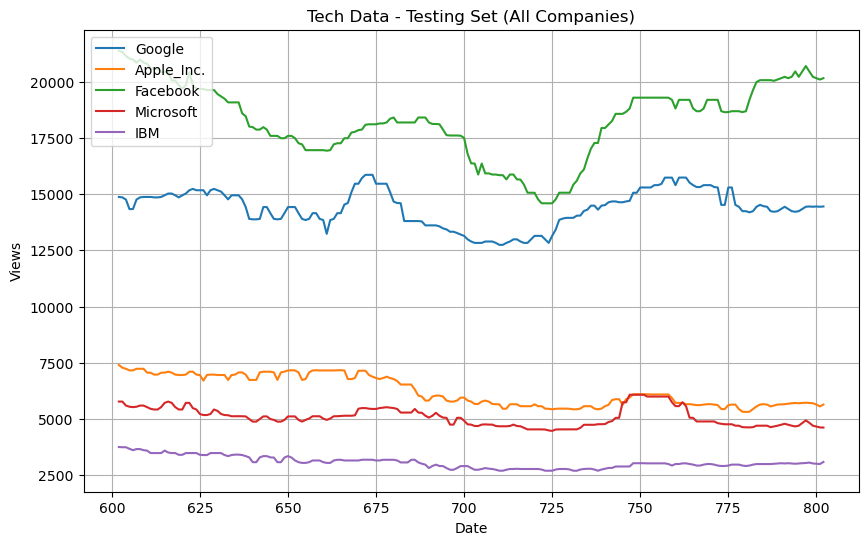

smoothed_test_politics shape: (5, 201)
time_test_politics shape: (201,)


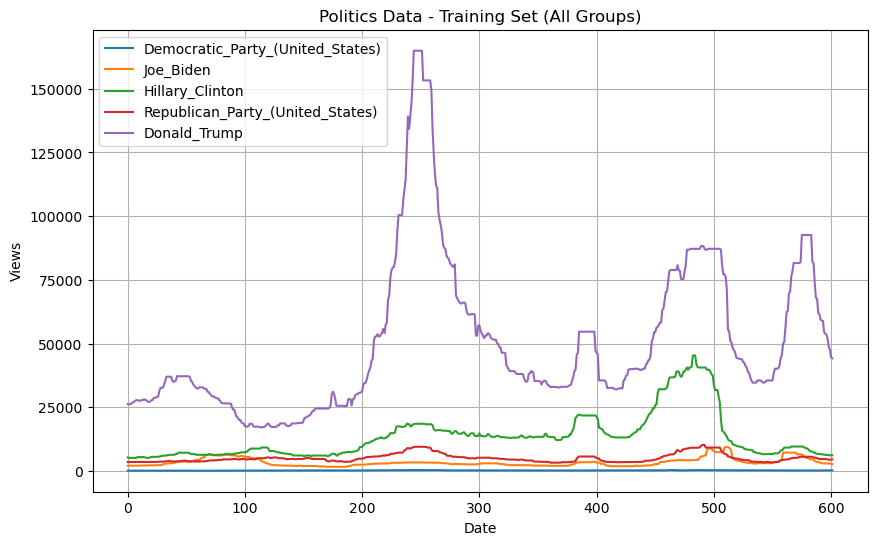

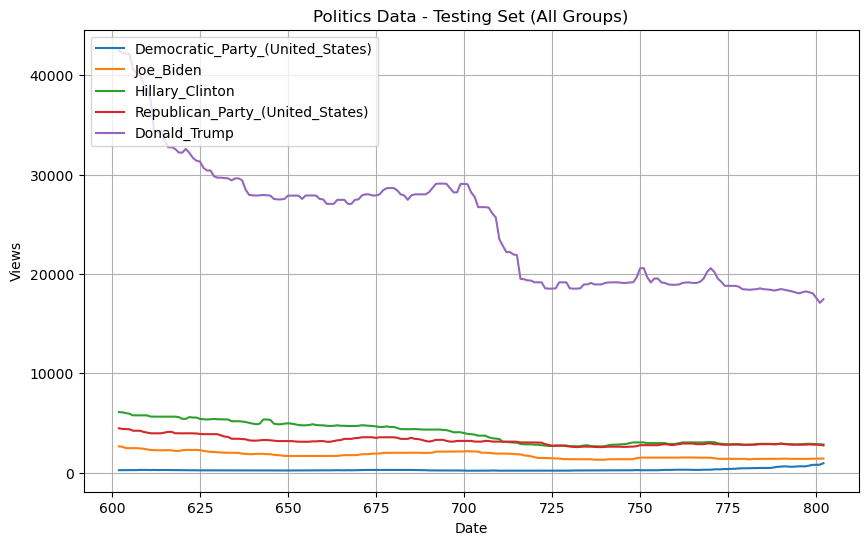

In [5]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# --- Soccer Data ---
# Extract names and values for soccer data
soccer_names, soccer_values = extract_names_and_values(soccer)

# Add feature names for soccer
soccer_feature_names = ["time_step"] + soccer_names

# Apply smoothing to soccer data
smoothed_soccer = smooth_data(soccer_values)

# Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(
    soccer, train_ratio=0.75, target_column=0
)

# Generate integer day labels
time_train_soccer = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test_soccer = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Plot all soccer teams in the training set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_soccer[:, :X_train_soccer.shape[0]],
    dates=time_train_soccer,
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_group(
    names=soccer_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_soccer[:, X_train_soccer.shape[0]:],
    dates=time_test_soccer,
    title="Soccer Data - Testing Set (All Teams)"
)

# --- Tech Data ---
# Extract names and values for tech data
tech_names, tech_values = extract_names_and_values(tech)

# Add feature names for tech
tech_feature_names = ["time_step"] + tech_names

# Apply smoothing to tech data
smoothed_tech = smooth_data(tech_values)

# Split Tech data into training and testing sets
X_train_tech, X_test_tech, y_train_tech, y_test_tech = split_train_test_matrix(
    smoothed_tech, train_ratio=0.75, target_column=0, smoothed=True  # Use smoothed=True for smoothed data
)

# Generate integer day labels for Tech
time_train_tech = np.arange(X_train_tech.shape[0])
time_test_tech = np.arange(X_train_tech.shape[0], X_train_tech.shape[0] + X_test_tech.shape[0])

# Adjust slicing for smoothed test data
smoothed_test_tech = smoothed_tech[:, X_train_tech.shape[0]:]
time_test_tech = time_test_tech[:smoothed_test_tech.shape[1]]  # Ensure time axis matches smoothed_values

# Debugging shapes
print("smoothed_test_tech shape:", smoothed_test_tech.shape)
print("time_test_tech shape:", time_test_tech.shape)

# Plot all tech companies in the training set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_tech[:, :X_train_tech.shape[0]],
    dates=time_train_tech,
    title="Tech Data - Training Set (All Companies)"
)

# Plot all tech companies in the testing set
plot_group(
    names=tech_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_test_tech,
    dates=time_test_tech,
    title="Tech Data - Testing Set (All Companies)"
)


# --- Politics Data ---
# Extract names and values for politics data
politics_names, politics_values = extract_names_and_values(politics)

# Add feature names for politics
politics_feature_names = ["time_step"] + politics_names

# Apply smoothing to politics data
smoothed_politics = smooth_data(politics_values)

# Split Politics data into training and testing sets
X_train_politics, X_test_politics, y_train_politics, y_test_politics = split_train_test_matrix(
    smoothed_politics, train_ratio=0.75, target_column=0, smoothed=True  # Use smoothed=True for smoothed data
)

# Generate integer day labels for Politics
time_train_politics = np.arange(X_train_politics.shape[0])
time_test_politics = np.arange(X_train_politics.shape[0], X_train_politics.shape[0] + X_test_politics.shape[0])

# Adjust slicing for smoothed test data
smoothed_test_politics = smoothed_politics[:, X_train_politics.shape[0]:]
time_test_politics = time_test_politics[:smoothed_test_politics.shape[1]]  # Ensure time axis matches smoothed_values

# Debugging shapes
print("smoothed_test_politics shape:", smoothed_test_politics.shape)
print("time_test_politics shape:", time_test_politics.shape)

# Plot all political groups in the training set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_politics[:, :X_train_politics.shape[0]],
    dates=time_train_politics,
    title="Politics Data - Training Set (All Groups)"
)

# Plot all political groups in the testing set
plot_group(
    names=politics_feature_names[1:],  # Exclude "time_step"
    smoothed_values=smoothed_test_politics,
    dates=time_test_politics,
    title="Politics Data - Testing Set (All Groups)"
)


# Soccer Data
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [6]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train_soccer, num_inducing=100)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams(X_train):
    # Determine the number of input dimensions from X_train
    dims = X_train.shape[1]
    
    # Three initial weights in log space for unconstrained optimization (converted to float)
    initial_weights = [0, 0, 0, 0, 0]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0]       # [noise_variance, signal_variance, length_scale]
    hyperparams_sinusoidal = [0.1, 1.0, 10.0, 1.0]  # [noise_variance, signal_variance, period, length_scale]

    # Initialize spectral mixture hyperparameters
    num_mixtures = 10
    hyperparams_spectralmixture = [0.1]  # Start with noise_variance and number of mixtures

    for _ in range(num_mixtures):
        weight = 1 / num_mixtures  # Equal weight for each mixture initially
        mean = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        variance = random.uniform(grab_prng(), shape=(dims,), minval=-5, maxval=5).tolist()
        hyperparams_spectralmixture.append(weight)  # Add weight
        hyperparams_spectralmixture.extend(mean)  # Add flattened mean
        hyperparams_spectralmixture.extend(variance)  # Add flattened variance
    #

    # Concatenate all hyperparameters
    initial_params = (
        initial_weights +
        hyperparams_sqexp +
        hyperparams_linear +
        hyperparams_matern +
        hyperparams_sinusoidal +
        hyperparams_spectralmixture
    )
    
    return np.array(initial_params, dtype=np.float32)
#


# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_soccer)

## Define the Optimization Loop for ELBO

In [7]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_soccer, y_train_soccer, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -541385863.365709
Step 10, ELBO: -19471.992883938623
Step 20, ELBO: -19415.039499677576
Step 30, ELBO: -19358.470162449416
Step 40, ELBO: -19302.268784066397
Step 50, ELBO: -19246.446377341945
Step 60, ELBO: -19191.00395933832
Step 70, ELBO: -19135.91969746482
Step 80, ELBO: -19081.224676859372
Step 90, ELBO: -19026.885241496784
Step 100, ELBO: -18972.89677060969
Step 110, ELBO: -18919.274564202813
Step 120, ELBO: -18866.001004730057
Step 130, ELBO: -18813.071563064805
Step 140, ELBO: -18760.48635873762
Step 150, ELBO: -18708.25570146441
Step 160, ELBO: -18656.36473765721
Step 170, ELBO: -18604.811296747892
Step 180, ELBO: -18553.57537151821
Step 190, ELBO: -18502.671785880106
Optimized Hyperparameters: [1.17910480e+00 1.00001311e+00 1.68965983e+00 1.03018343e+00
 1.95131755e+00 4.50492344e+04 3.20514894e+00 2.20518984e+04
 4.50492344e+04 2.71831465e+00 4.50492344e+04 4.59298229e+00
 1.05959648e+04 4.50492344e+04 2.80034089e+00 2.20264648e+04
 2.71837735e+00 4.50492344e+0

In [8]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 225246.17


## Predict and Plot the Results

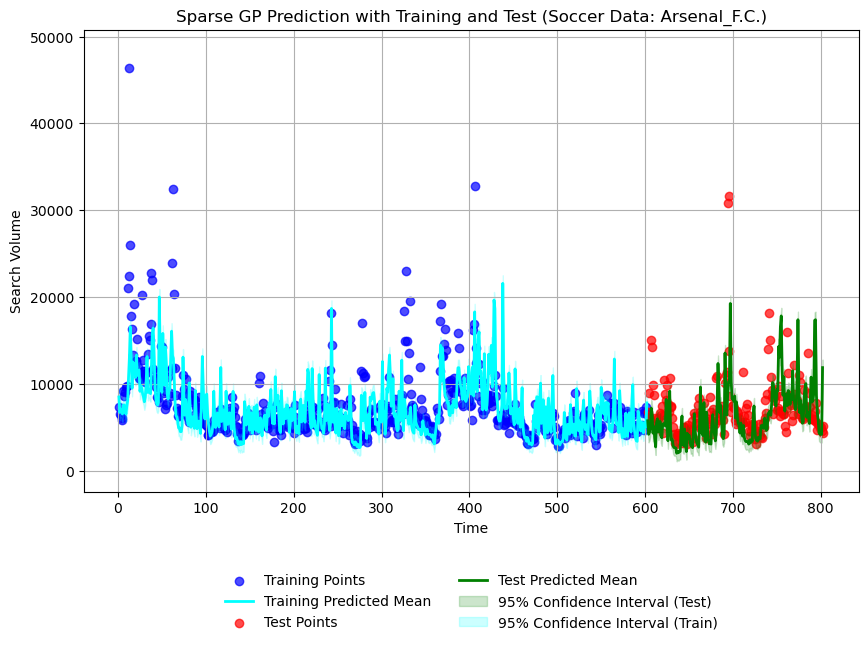

In [9]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_soccer, 
    y_train_soccer, 
    X_test_soccer, 
    y_test_soccer, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Soccer Data: {soccer_feature_names[-1]})"
)

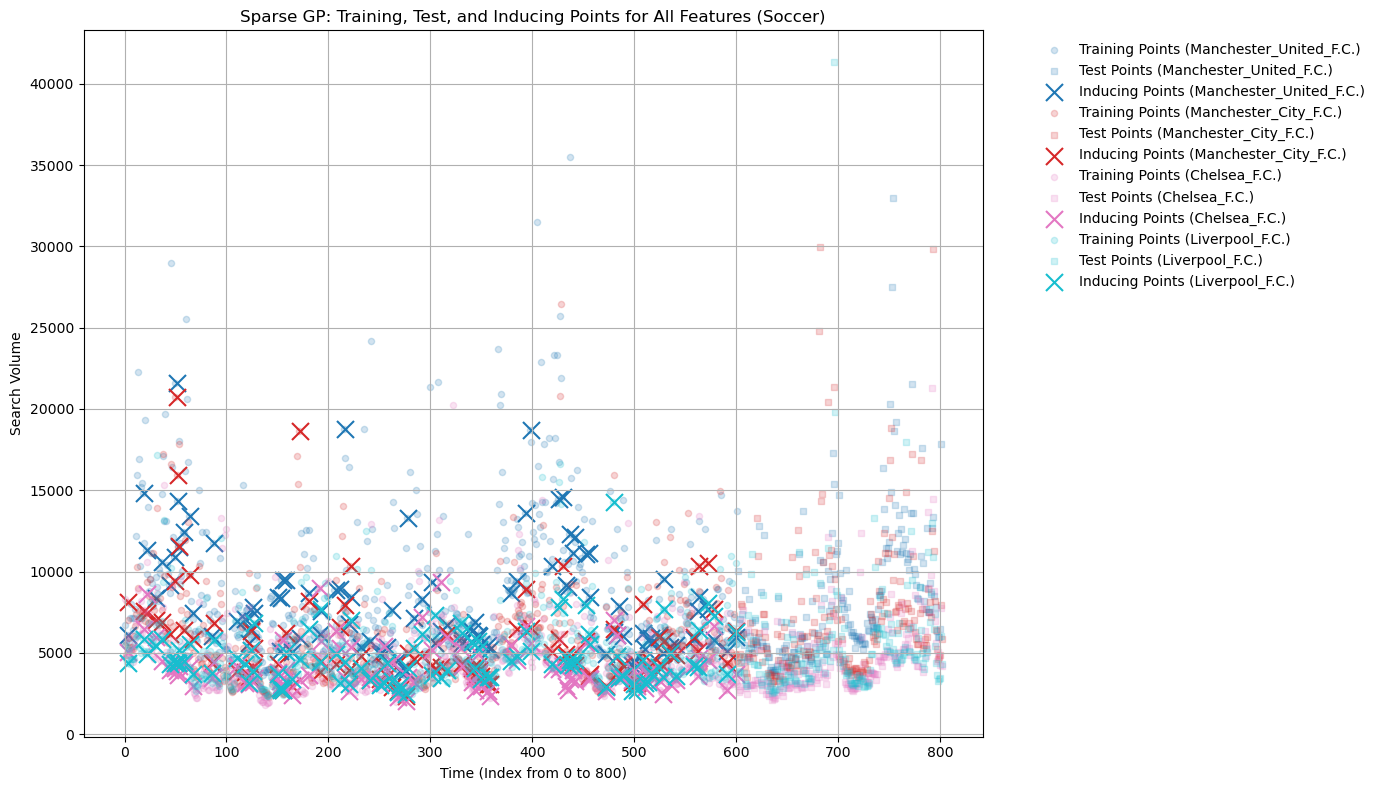

In [10]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_soccer, y_train_soccer, X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Soccer)", feature_names=soccer_feature_names
)

In [11]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_soccer.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.1791
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.6897
Kernel 4 (Sinusoidal): 1.0302
Kernel 5 (Spectral Mixture): 1.9513

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 17.21%
Kernel 2 (Linear): 14.60%
Kernel 3 (Matérn): 24.67%
Kernel 4 (Sinusoidal): 15.04%
Kernel 5 (Spectral Mixture): 28.49%

Other Hyperparameters:
Kernel 1 - Noise Variance: 45049.2344
Kernel 1 - Signal Variance: 3.2051
Kernel 1 - Length Scale: 22051.8984
Kernel 2 - Noise Variance: 45049.2344
Kernel 2 - Signal Variance: 2.7183
Kernel 3 - Noise Variance: 45049.2344
Kernel 3 - Signal Variance: 4.5930
Kernel 3 - Length Scale: 10595.9648
Kernel 4 - Noise Variance: 45049.2344
Kernel 4 - Signal Variance: 2.8003
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7184
Kernel 5 - Noise Variance: 45049.2344

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1816
Means: [0.22082484 0.8361463  0.0082743  1.3717978  3.6921637 ]
Variances: [1.78990135e+01 3.2699

## NLPD

In [12]:
train_nlpd = calculate_nlpd(X_train_soccer, y_train_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)
test_nlpd = calculate_nlpd(X_test_soccer, y_test_soccer, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_soccer, y_train_soccer)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 20.7366
Test NLPD: 25.3524


## MSE

In [13]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_soccer, X_train_soccer, y_train_soccer, Z, optimized_hyperparams)
mse = calculate_mse(y_test_soccer, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16151239.8946


## ELBO Maximization

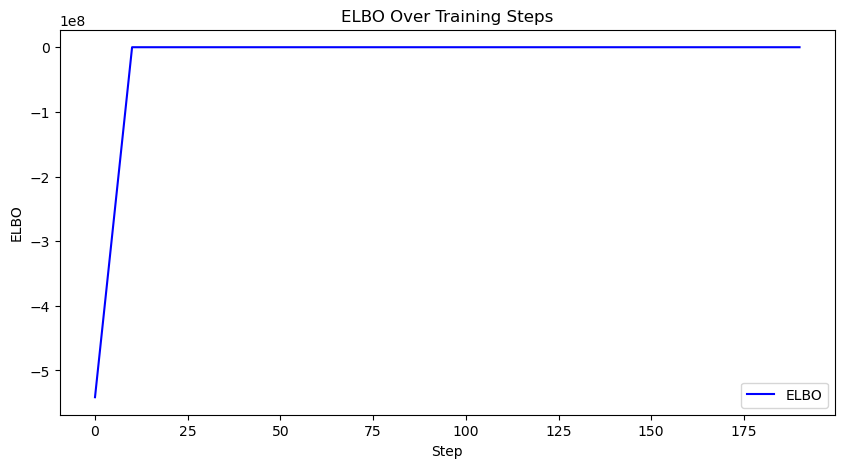

In [14]:
plot_elbo(history)

## Kernel Hyperparameters

Unchanged Hyperparameters:
 - Signal Variance (Sq-Exp)
 - Length Scale (Sq-Exp)
 - Signal Variance (Linear)
 - Length Scale (Matern)
 - Length Scale (Sinusoidal)
 - Period (Sinusoidal)
 - SM Weight 1
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Weight 2
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Weight 3
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Weight 4
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM M

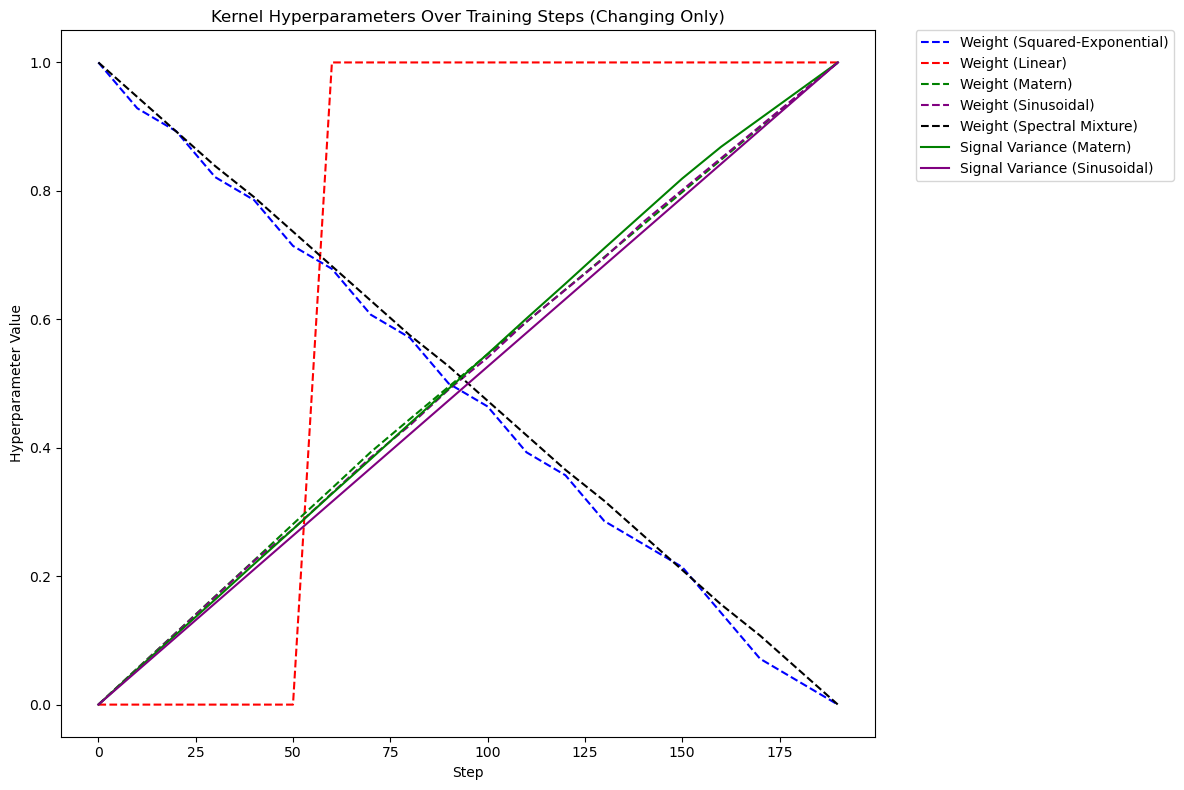

In [15]:
plot_kernel_hyperparameters(history, dims=5)

## Political Data

In [16]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_politics,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_politics)


In [17]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_politics, y_train_politics, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -41250.98584088397
Step 10, ELBO: -40951.315331520476
Step 20, ELBO: -40655.970708742054
Step 30, ELBO: -40365.26204391912
Step 40, ELBO: -40078.789080951334
Step 50, ELBO: -39796.636779645996
Step 60, ELBO: -39518.52591109298
Step 70, ELBO: -39244.51450425105
Step 80, ELBO: -38974.468808008955
Step 90, ELBO: -38708.38144077277
Step 100, ELBO: -38446.30687518919
Step 110, ELBO: -38187.68512589323
Step 120, ELBO: -37932.56261475095
Step 130, ELBO: -37681.41849303585
Step 140, ELBO: -37433.43816164935
Step 150, ELBO: -37188.88605051818
Step 160, ELBO: -36947.95353950608
Step 170, ELBO: -36710.235333219876
Step 180, ELBO: -36475.640021664134
Step 190, ELBO: -36244.22047333609
Optimized Hyperparameters: [1.02339828e+00 9.99975026e-01 1.02780008e+00 1.00582349e+00
 9.82894599e-01 1.27398956e+00 2.78188419e+00 2.22227129e+04
 1.27398956e+00 2.71821642e+00 1.27398956e+00 2.79384923e+00
 2.15490586e+04 1.27398956e+00 2.73411202e+00 2.20264648e+04
 2.71826363e+00 1.27398956e+00 1.

In [18]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 6.369948


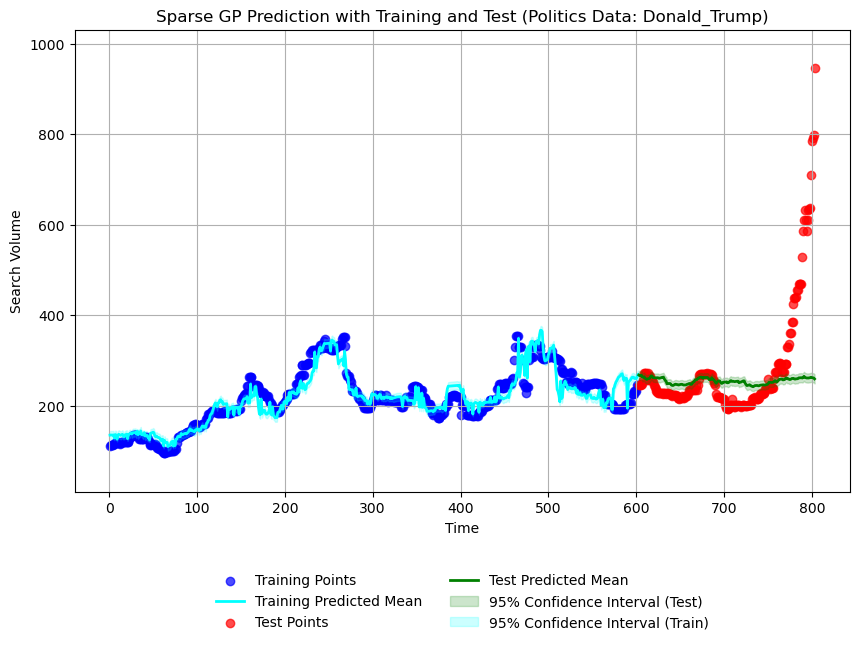

In [19]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_politics, 
    y_train_politics, 
    X_test_politics, 
    y_test_politics, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (Politics Data: {politics_feature_names[-1]})"
)

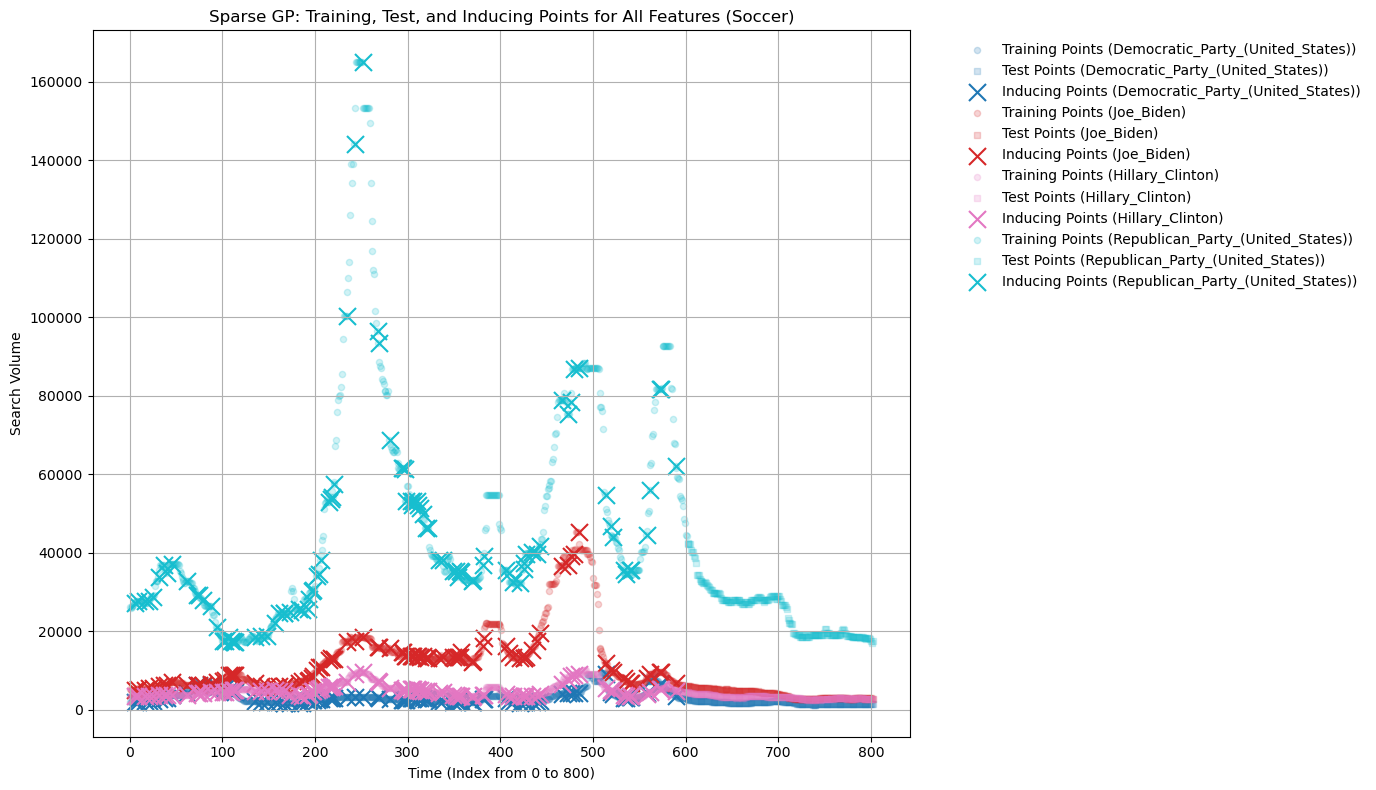

In [20]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_politics, y_train_politics, X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Politics)", feature_names=politics_feature_names
)

In [21]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_politics.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 1.0234
Kernel 2 (Linear): 1.0000
Kernel 3 (Matérn): 1.0278
Kernel 4 (Sinusoidal): 1.0058
Kernel 5 (Spectral Mixture): 0.9829

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 20.31%
Kernel 2 (Linear): 19.84%
Kernel 3 (Matérn): 20.39%
Kernel 4 (Sinusoidal): 19.96%
Kernel 5 (Spectral Mixture): 19.50%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.2740
Kernel 1 - Signal Variance: 2.7819
Kernel 1 - Length Scale: 22222.7129
Kernel 2 - Noise Variance: 1.2740
Kernel 2 - Signal Variance: 2.7182
Kernel 3 - Noise Variance: 1.2740
Kernel 3 - Signal Variance: 2.7938
Kernel 3 - Length Scale: 21549.0586
Kernel 4 - Noise Variance: 1.2740
Kernel 4 - Signal Variance: 2.7341
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 1.2740

Spectral Mixture Kernel - Mixture 1:
Weight: 1.1033
Means: [ 0.03792665  0.06898853  0.55418867 15.03691     0.10657929]
Variances: [0.06002247 1.9542322  3.6322849  0.0

In [22]:
train_nlpd = calculate_nlpd(X_train_politics, y_train_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)
test_nlpd = calculate_nlpd(X_test_politics, y_test_politics, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_politics, y_train_politics)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 15.2710
Test NLPD: 252.8653


In [23]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_politics, X_train_politics, y_train_politics, Z, optimized_hyperparams)
mse = calculate_mse(y_test_politics, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 16440.2013


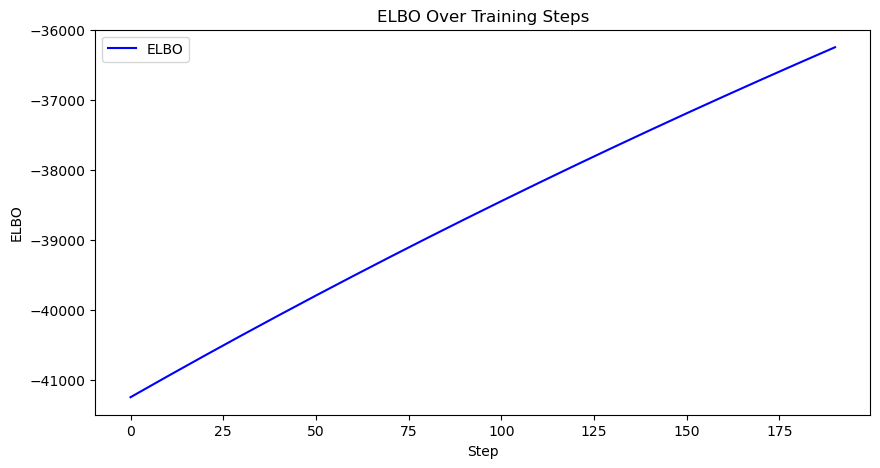

In [24]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


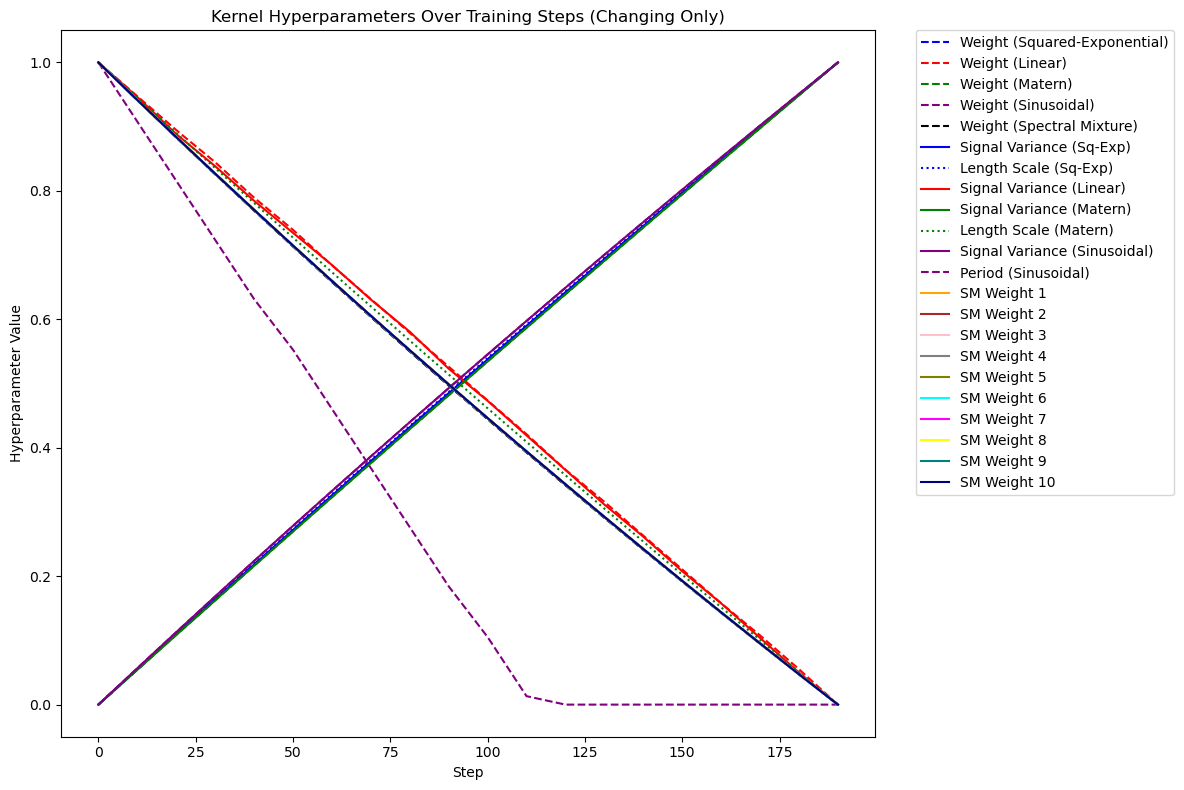

In [25]:
plot_kernel_hyperparameters(history, dims=5)

## Tech data

In [26]:
grab_prng()
#init inducing points + unconstrained HPs
Z= initialize_inducing_points(X_train_tech,100)
unconstrained_hyperparams_init = random_init_combined_hyperparams(X_train_tech)


In [27]:
# Set the gradient ascent step size and number of steps
step_size = 1e-7
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train_tech, y_train_tech, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -138818816.00592405
Step 10, ELBO: -3124972.26468963
Step 20, ELBO: -1506389.5121824509
Step 30, ELBO: -966970.4071545501
Step 40, ELBO: -714817.9769664607
Step 50, ELBO: -580301.3094035925
Step 60, ELBO: -496193.3832521084
Step 70, ELBO: -437022.103359151
Step 80, ELBO: -392364.4752066327
Step 90, ELBO: -357156.9183098989
Step 100, ELBO: -328547.2330759324
Step 110, ELBO: -304757.59922474844
Step 120, ELBO: -284606.36152545223
Step 130, ELBO: -267273.6496856182
Step 140, ELBO: -252173.65282971362
Step 150, ELBO: -238876.03581122935
Step 160, ELBO: -227058.00484903113
Step 170, ELBO: -216471.92344262393
Step 180, ELBO: -206924.06995403158
Step 190, ELBO: -198260.9031886004
Optimized Hyperparameters: [4.43144913e+01 1.00066817e+00 1.47169411e+00 1.06215203e+00
 6.32722974e-01 1.66666672e+02 1.20459160e+02 1.14931500e+06
 1.66666672e+02 2.72008824e+00 1.66666672e+02 4.00047874e+00
 1.01528877e+04 1.66666672e+02 2.88723135e+00 2.20264648e+04
 2.71827459e+00 1.66666672e+02 1.

In [28]:
# Total noise variance
total_noise = np.sum(np.array([optimized_hyperparams[i] for i in [5, 8, 10, 13, 17]]))
print("\nTotal noise:", total_noise)


Total noise: 833.3334


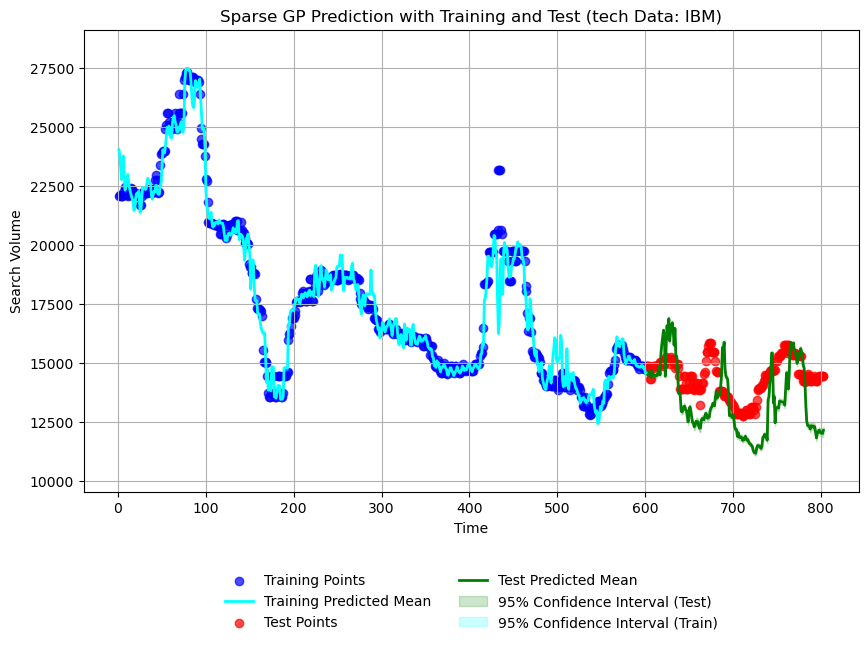

In [29]:
plot_sparse_gp_with_uncertainty_clean(
    X_train_tech, 
    y_train_tech, 
    X_test_tech, 
    y_test_tech, 
    Z, 
    optimized_hyperparams, 
    sparse_gp_posterior_predictive, 
    title_suffix=f" (tech Data: {tech_feature_names[-1]})"
)

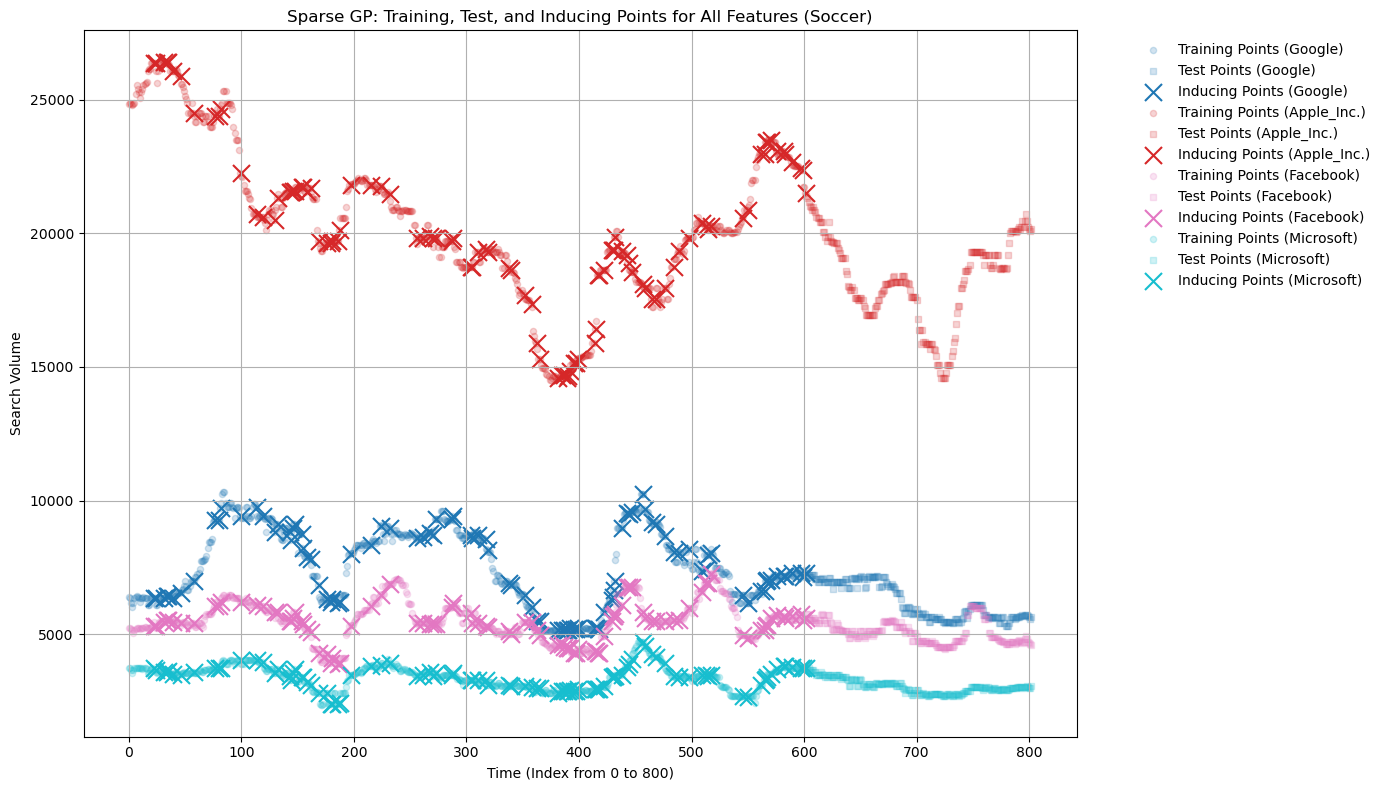

In [30]:
plot_sparse_gp_with_uncertainty_inducing(
    X_train_tech, y_train_tech, X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, title_suffix=" (Tech)", feature_names=tech_feature_names
)

In [31]:
# Extract weights
weights = optimized_hyperparams[:5]
weight_percentages = (weights / np.sum(weights)) * 100

# Print the weights
print("Kernel Weights:")
print(f"Kernel 1 (Squared-Exponential): {weights[0]:.4f}")
print(f"Kernel 2 (Linear): {weights[1]:.4f}")
print(f"Kernel 3 (Matérn): {weights[2]:.4f}")
print(f"Kernel 4 (Sinusoidal): {optimized_hyperparams[3]:.4f}")
print(f"Kernel 5 (Spectral Mixture): {optimized_hyperparams[4]:.4f}")

# Print weights as percentages for each kernel
print("\nKernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")
print(f"Kernel 4 (Sinusoidal): {weight_percentages[3]:.2f}%")
print(f"Kernel 5 (Spectral Mixture): {weight_percentages[4]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[11]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[12]:.4f}")
print(f"Kernel 4 - Noise Variance: {optimized_hyperparams[13]:.4f}")
print(f"Kernel 4 - Signal Variance: {optimized_hyperparams[14]:.4f}")
print(f"Kernel 4 - Period: {optimized_hyperparams[15]:.4f}")
print(f"Kernel 4 - Length Scale: {optimized_hyperparams[16]:.4f}")
print(f"Kernel 5 - Noise Variance: {optimized_hyperparams[17]:.4f}")

# Print rest of the hyperparameters for the spectral mixture kernel
dim = X_train_tech.shape[1]
i = 18
mixture_count = 1
while i < len(optimized_hyperparams):
    print(f"\nSpectral Mixture Kernel - Mixture {mixture_count}:")
    print(f"Weight: {optimized_hyperparams[i: i + 1][0]:.4f}")
    print(f"Means: {optimized_hyperparams[i + 1: i + 1 + dim]}")
    print(f"Variances: {optimized_hyperparams[i + 1 + dim: i + 1 + 2 * dim]}")
    i += 1 + 2 * dim
    mixture_count += 1
#

Kernel Weights:
Kernel 1 (Squared-Exponential): 44.3145
Kernel 2 (Linear): 1.0007
Kernel 3 (Matérn): 1.4717
Kernel 4 (Sinusoidal): 1.0622
Kernel 5 (Spectral Mixture): 0.6327

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 91.40%
Kernel 2 (Linear): 2.06%
Kernel 3 (Matérn): 3.04%
Kernel 4 (Sinusoidal): 2.19%
Kernel 5 (Spectral Mixture): 1.31%

Other Hyperparameters:
Kernel 1 - Noise Variance: 166.6667
Kernel 1 - Signal Variance: 120.4592
Kernel 1 - Length Scale: 1149315.0000
Kernel 2 - Noise Variance: 166.6667
Kernel 2 - Signal Variance: 2.7201
Kernel 3 - Noise Variance: 166.6667
Kernel 3 - Signal Variance: 4.0005
Kernel 3 - Length Scale: 10152.8877
Kernel 4 - Noise Variance: 166.6667
Kernel 4 - Signal Variance: 2.8872
Kernel 4 - Period: 22026.4648
Kernel 4 - Length Scale: 2.7183
Kernel 5 - Noise Variance: 166.6667

Spectral Mixture Kernel - Mixture 1:
Weight: 1.0557
Means: [1.1550237e+00 2.0058496e-02 1.4527072e+02 3.9950311e-01 3.2242358e-02]
Variances: [0.01429897 2.15

In [32]:
train_nlpd = calculate_nlpd(X_train_tech, y_train_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)
test_nlpd = calculate_nlpd(X_test_tech, y_test_tech, Z, optimized_hyperparams, sparse_gp_posterior_predictive, X_train_tech, y_train_tech)

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

Train NLPD: 103.5481
Test NLPD: 272.0069


In [33]:
Y_pred, _ = sparse_gp_posterior_predictive(X_test_tech, X_train_tech, y_train_tech, Z, optimized_hyperparams)
mse = calculate_mse(y_test_tech, Y_pred) 
print(f"MSE: {mse:.4f}")

MSE: 2340576.1185


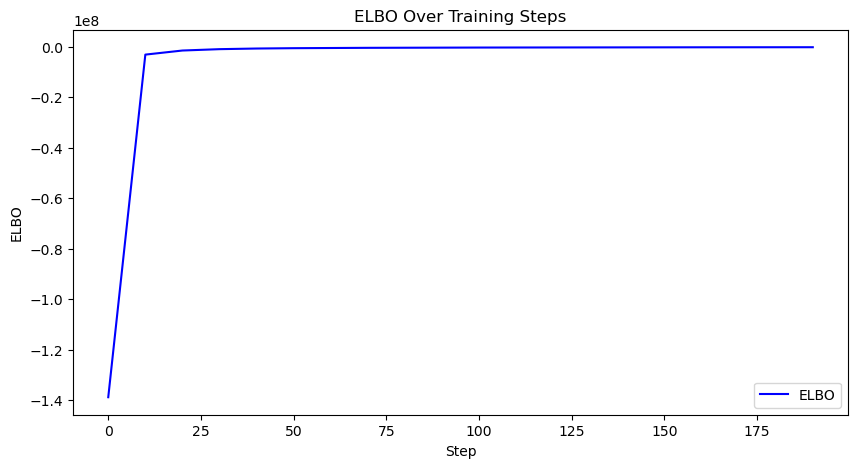

In [34]:
plot_elbo(history)

Unchanged Hyperparameters:
 - Length Scale (Sinusoidal)
 - SM Mean 1, Dim 1
 - SM Variance 1, Dim 1
 - SM Mean 1, Dim 2
 - SM Variance 1, Dim 2
 - SM Mean 1, Dim 3
 - SM Variance 1, Dim 3
 - SM Mean 1, Dim 4
 - SM Variance 1, Dim 4
 - SM Mean 1, Dim 5
 - SM Variance 1, Dim 5
 - SM Mean 2, Dim 1
 - SM Variance 2, Dim 1
 - SM Mean 2, Dim 2
 - SM Variance 2, Dim 2
 - SM Mean 2, Dim 3
 - SM Variance 2, Dim 3
 - SM Mean 2, Dim 4
 - SM Variance 2, Dim 4
 - SM Mean 2, Dim 5
 - SM Variance 2, Dim 5
 - SM Mean 3, Dim 1
 - SM Variance 3, Dim 1
 - SM Mean 3, Dim 2
 - SM Variance 3, Dim 2
 - SM Mean 3, Dim 3
 - SM Variance 3, Dim 3
 - SM Mean 3, Dim 4
 - SM Variance 3, Dim 4
 - SM Mean 3, Dim 5
 - SM Variance 3, Dim 5
 - SM Mean 4, Dim 1
 - SM Variance 4, Dim 1
 - SM Mean 4, Dim 2
 - SM Variance 4, Dim 2
 - SM Mean 4, Dim 3
 - SM Variance 4, Dim 3
 - SM Mean 4, Dim 4
 - SM Variance 4, Dim 4
 - SM Mean 4, Dim 5
 - SM Variance 4, Dim 5
 - SM Mean 5, Dim 1
 - SM Variance 5, Dim 1
 - SM Mean 5, Dim 2


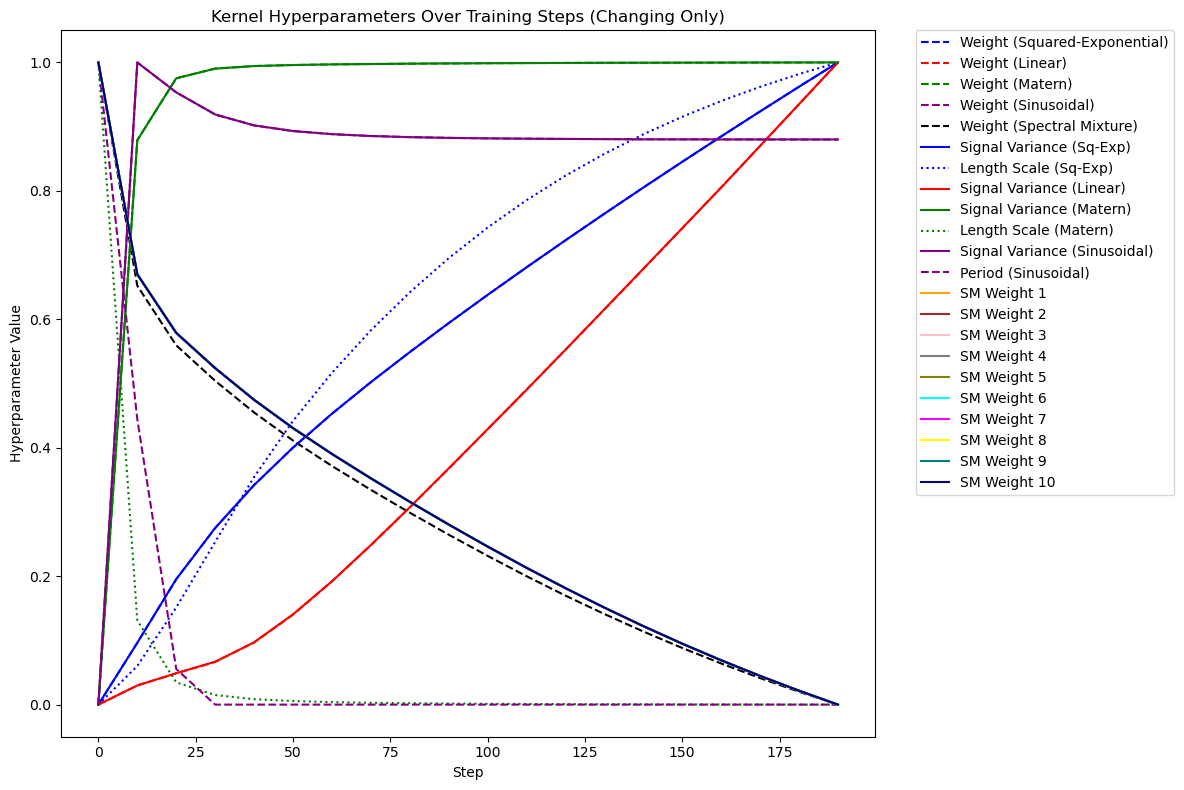

In [35]:
plot_kernel_hyperparameters(history, dims=5)